# Attend-and-Excite の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/5-2-1_attend-and-excite.ipynb)

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
seed = 42

warnings.simplefilter("ignore")

## オリジナルの StableDiffusionPipeline の読み込み

In [3]:
from diffusers import StableDiffusionPipeline

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"

pipe_sd = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=dtype
)
pipe_sd = pipe_sd.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Attend and Excite を実装した StableDiffusionAttendAndExcitePipeline の読み込み

In [4]:
from diffusers import StableDiffusionAttendAndExcitePipeline

pipe_ae = (
    StableDiffusionAttendAndExcitePipeline.from_pretrained(
        model_id, torch_dtype=dtype
    )
)
pipe_ae = pipe_ae.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## StableDiffusion での画像生成

In [5]:
from diffusers.utils import make_image_grid

prompt = "A horse and a dog"

images_sd = pipe_sd(
    prompt,
    num_images_per_prompt=2,
    generator=torch.manual_seed(seed),
).images

  0%|          | 0/50 [00:00<?, ?it/s]

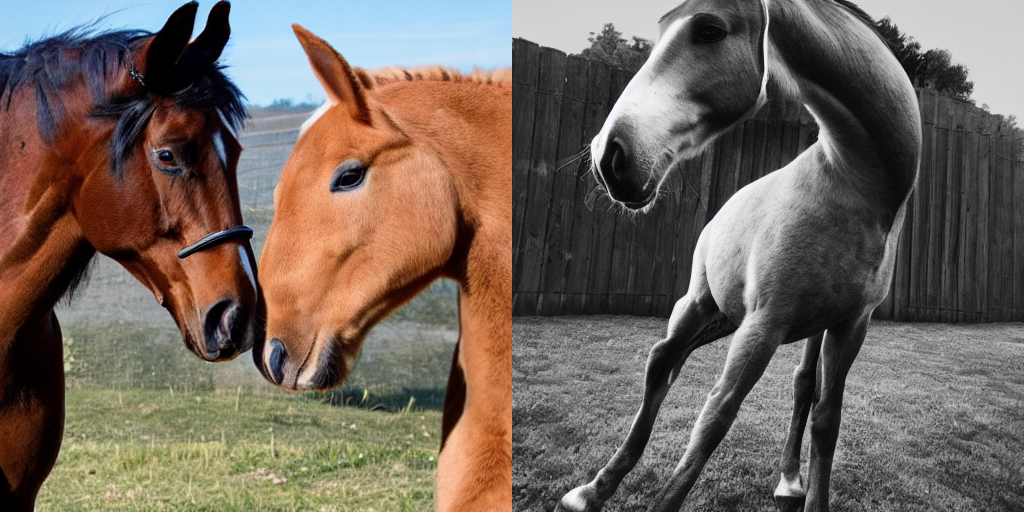

In [6]:
gen_result_sd = make_image_grid(
    images=images_sd, rows=1, cols=2
)
gen_result_sd

## Attend and Excite を適用した Stable Diffusion での画像生成

In [7]:
# `get_indices` 関数を使用して、対象のトークン（horse と dog）のインデックスを調べる
# 2 と 5 がそれぞれ horse と dog であることを確認
print(f"Indicies: {pipe_ae.get_indices(prompt)}")

Indicies: {0: '<|startoftext|>', 1: 'a</w>', 2: 'horse</w>', 3: 'and</w>', 4: 'a</w>', 5: 'dog</w>', 6: '<|endoftext|>'}


In [8]:
# 上記で調べたトークンのインデックスを指定
token_indices = [2, 5]

# Attend-and-Excite パイプラインによって画像を生成
images_ae = pipe_ae(
    prompt,
    num_images_per_prompt=2,
    generator=torch.manual_seed(seed),
    #
    # Additional arguments for Attend-and-Excite
    # 対象のトークンを指定
    #
    token_indices=token_indices,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

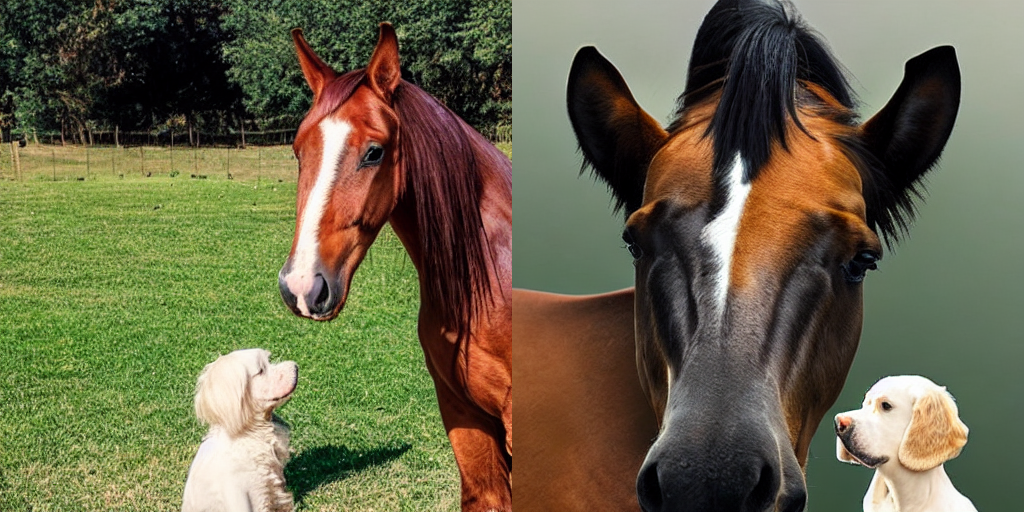

In [9]:
gen_result_ae = make_image_grid(
    images=images_ae, rows=1, cols=2
)
gen_result_ae

## 生成結果の比較

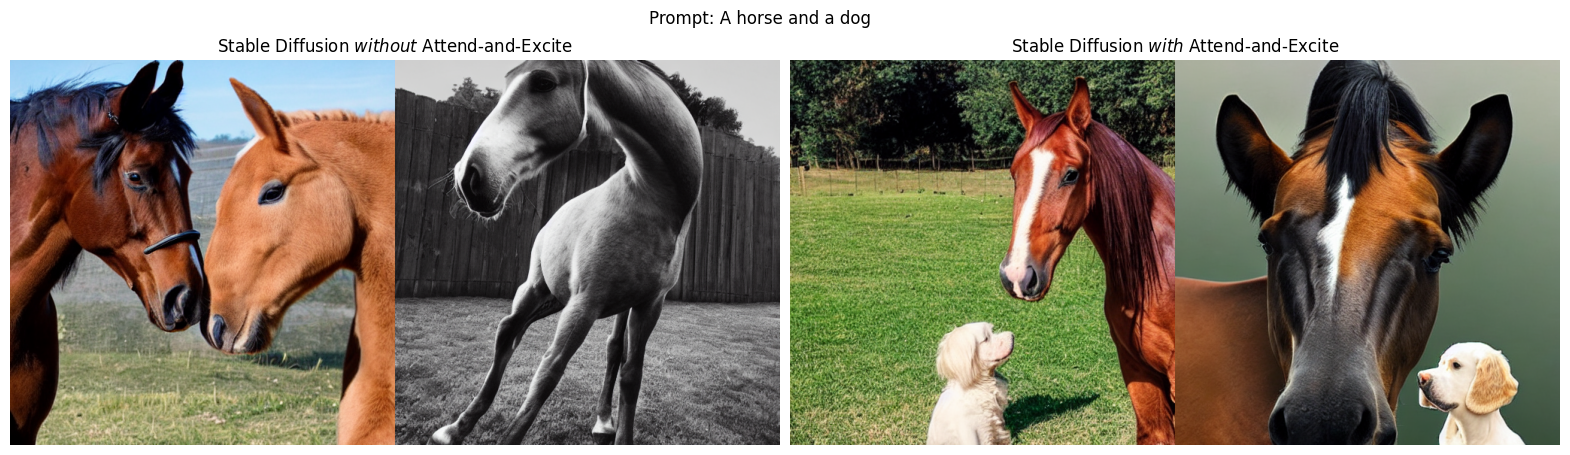

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 5))
grid = ImageGrid(
    fig,
    rect=111,
    nrows_ncols=(1, 2),
    axes_pad=0.1,
)
fig.suptitle(f"Prompt: {prompt}")

images = [
    gen_result_sd,
    gen_result_ae,
]
titles = [
    r"Stable Diffusion ${\it without}$ Attend-and-Excite",
    r"Stable Diffusion ${\it with}$ Attend-and-Excite",
]
for i, (image, title) in enumerate(zip(images, titles)):
    grid[i].imshow(image)
    grid[i].axis("off")
    grid[i].set_title(title)